In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
import h5py
from tqdm import tqdm
import pandas as pd
from utils import print_statistics, load_dataset, scale_and_center_tensors, create_hosvd_reconstruction_gif
import global_variables


In [3]:
n_snapshots = 200
subsample_x = 10
subsample_y = 10
paths = ["sharmapushan/hydrogen-jet-8000"]
data_paths = [kagglehub.dataset_download(name) for name in paths]
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)

Nx, Ny = metadata['global']['Nxyz']
Nx_sub, Ny_sub = Nx//subsample_x, Ny//subsample_y
print(Nx_sub, Ny_sub)

component_names = global_variables.component_names
n_species = global_variables.n_species
molar_masses = global_variables.molar_masses
file_key_map = global_variables.file_key_map
Lx, Ly = global_variables.Lx, global_variables.Ly

tensors = {path: load_dataset(path, component_names, file_key_map, Ny=Ny, Nx=Nx, n_snapshots=n_snapshots, molar_masses=molar_masses, subsample_x=10, subsample_y=10)
           for path in data_paths}


160 200
  Available components in dataset: ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']


In [4]:
tensors_scaled_log = scale_and_center_tensors(tensors, component_names)
tensors_scaled = scale_and_center_tensors(tensors, component_names, log_scale=False)


Log scaling and standardization complete.


Log scaling and standardization complete.



## Visualization and statistics

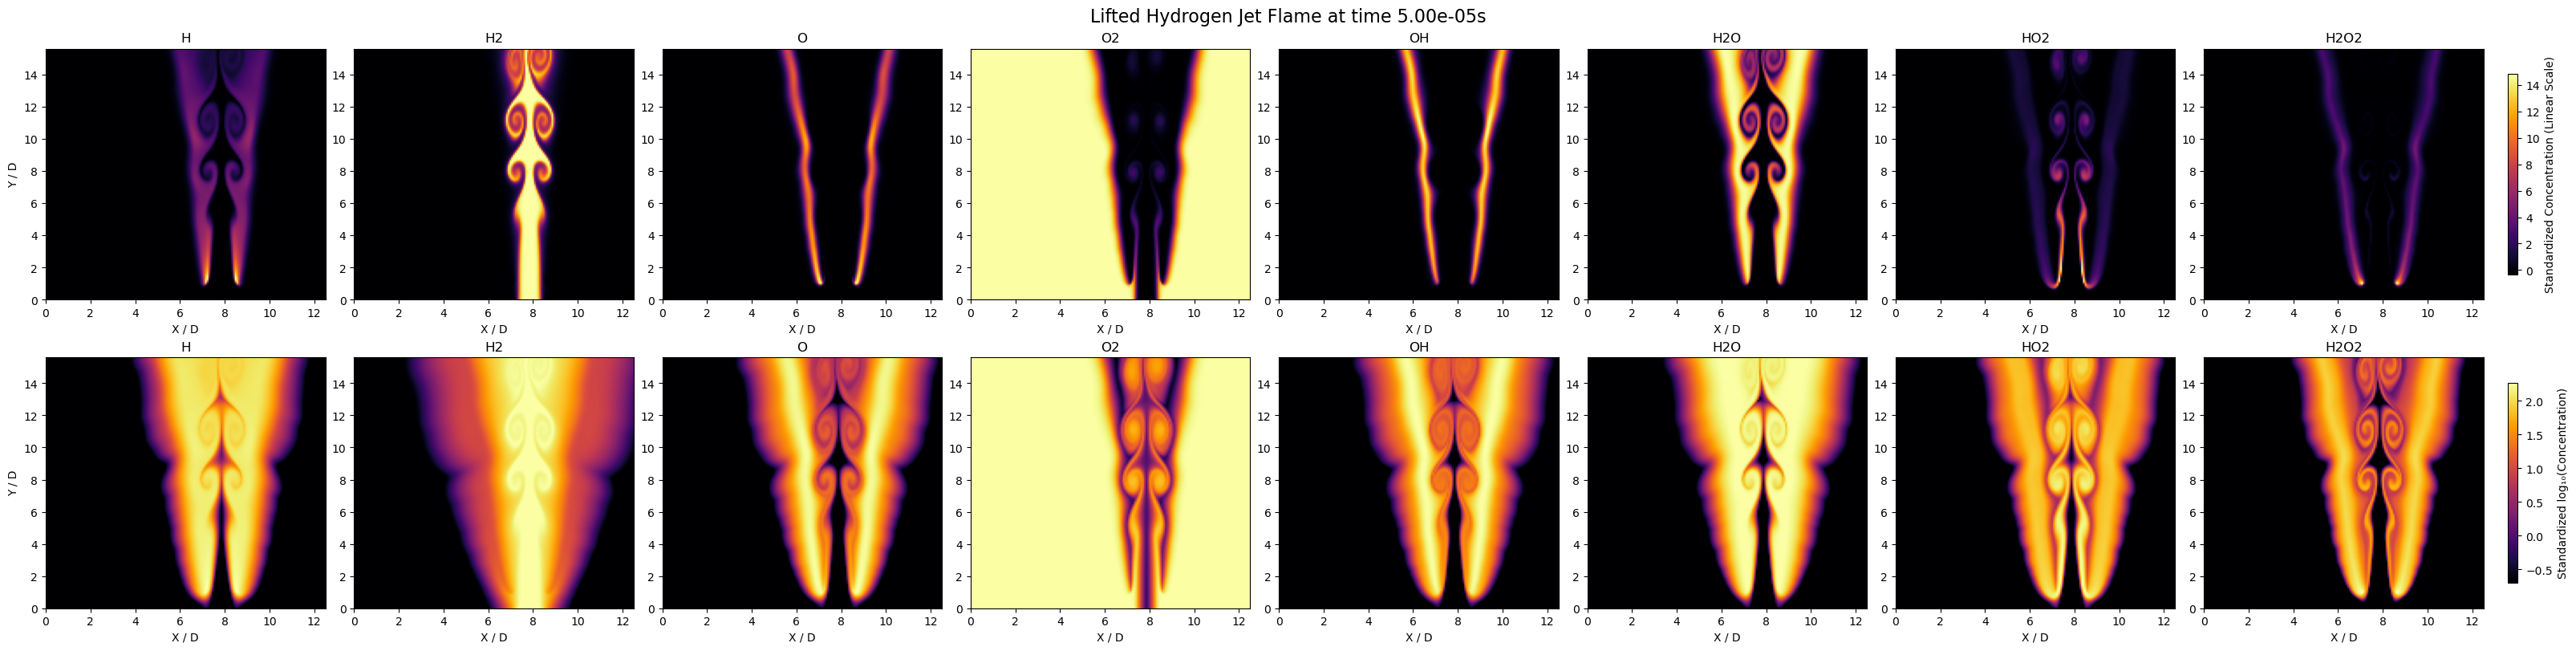

In [5]:
Lx, Ly = 12.5, 15.6        
x = np.linspace(0, Lx, Nx_sub)
y = np.linspace(0, Ly, Ny_sub)
t = 10
time_conversion_factor = 5e-06

fig, axes = plt.subplots(2, 8, figsize=(32, 8), constrained_layout=True)
fig.suptitle(f"Lifted Hydrogen Jet Flame at time {t * time_conversion_factor:.2e}s", fontsize=16)

tensor_plot = tensors_scaled[list(tensors_scaled.keys())[0]]
tensor_plot_log = tensors_scaled_log[list(tensors_scaled_log.keys())[0]]

for idx in range(8):
    im = axes[0, idx].imshow(
        tensor_plot[:, :, idx, t],
        cmap='inferno',
        origin='lower',
        extent=[0, Lx, 0, Ly],
        aspect='auto'
    )
    axes[0, idx].set_title(f"{component_names[idx][1:]}")
    axes[0, idx].set_xlabel("X / D")
    if idx == 0:
        axes[0, idx].set_ylabel("Y / D")

cbar1 = fig.colorbar(im, ax=axes[0, :], orientation='vertical', 
                      label="Standardized Concentration (Linear Scale)", 
                      pad=0.01, shrink=0.8)

for idx in range(8):
    im_log = axes[1, idx].imshow(
        tensor_plot_log[:, :, idx, t],
        cmap='inferno',
        origin='lower',
        extent=[0, Lx, 0, Ly],
        aspect='auto'
    )
    axes[1, idx].set_title(f"{component_names[idx][1:]}")
    axes[1, idx].set_xlabel("X / D")
    if idx == 0:
        axes[1, idx].set_ylabel("Y / D")

cbar2 = fig.colorbar(im_log, ax=axes[1, :], orientation='vertical', 
                      label="Standardized log₁₀(Concentration)", 
                      pad=0.01, shrink=0.8)

plt.show()

In [6]:
print_statistics(tensors_scaled_log, component_names)
print_statistics(tensors_scaled, component_names)


Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Component       Mean         Std          Min          Max         
--------------------------------------------------------------------------------
YH              -4.685319e-16 1.000000e+00 -7.390362e-01 1.829917e+00
YH2             -1.634248e-18 1.000000e+00 -9.803249e-01 1.661538e+00
YO              -1.730882e-16 1.000000e+00 -7.912339e-01 1.980622e+00
YO2             -2.188116e-16 1.000000e+00 -4.614561e+00 4.755012e-01
YOH             5.555023e-16 1.000000e+00 -7.994788e-01 1.899552e+00
YH2O            -1.043787e-15 1.000000e+00 -7.845123e-01 1.620886e+00
YHO2            -7.027268e-16 1.000000e+00 -7.896143e-01 1.935261e+00
YH2O2           3.703349e-16 1.000000e+00 -7.040717e-01 2.277220e+00
--------------------------------------------------------------------------------
Overall Tensor Statistics:
  Shape: (200, 160, 8, 200)
  Total elements: 51,200,000
  Memory size: 390.62 MB
  Global mea

## Classical PCA

In [7]:
pca_results = {}

for case_name, tensors_dict in [("Linear Scale", tensors_scaled), ("Log Scale", tensors_scaled_log)]:
    for dataset_path, tensor in tensors_dict.items():
        X = tensor.reshape(tensor.shape[0]*tensor.shape[1]*tensor.shape[3], tensor.shape[2])
        U, sigma, V = np.linalg.svd(X, full_matrices=False)
        loadings = V.T  # Now shape is (n_components x n_modes)
        
        summary_data = []
        for mode in range(n_species):
            mode_vector = np.abs(loadings[:, mode])
            total = np.sum(mode_vector)
            rel_contrib = 100 * mode_vector / total if total > 0 else np.zeros_like(mode_vector)
            top_indices = np.argsort(rel_contrib)[::-1]
            top_species = []
            for idx in top_indices:
                top_species.append(f"{component_names[idx]} ({rel_contrib[idx]:.1f}%)")
            
            summary_data.append({
                'Mode': mode + 1,
                '1st Species': top_species[0],
                '2nd Species': top_species[1],
                '3rd Species': top_species[2],
                '4th Species': top_species[3],
                '5th Species': top_species[4],
                '6th Species': top_species[5],
                '7th Species': top_species[6],
                '8th Species': top_species[7],
            })
        
        df_summary = pd.DataFrame(summary_data)
        print("\n" + "="*80)
        print(f"CONTRIBUTING SPECIES FOR EACH PCA MODE - {case_name}")
        print("="*80)
        print(df_summary.to_string(index=False))
        print("="*80)
        
        Phi = U
        print(f"\nSpatial modes shape: {U.shape}")
        T = np.diag(sigma) @ V
        energy = sigma**2
        energy_fraction = energy / np.sum(energy)
        print(f"Total spatial features: {X.shape[0]}")
        print("\nTop modes energy content:")
        for i in range(min(5, len(energy_fraction))):
            print(f"  Mode {i+1}: {energy_fraction[i]*100:.2f}%")
        
        # Store results
        pca_results[case_name] = {
            'Phi': Phi,
            'sigma': sigma,
            'energy_fraction': energy_fraction
        }
        


CONTRIBUTING SPECIES FOR EACH PCA MODE - Linear Scale
 Mode   1st Species  2nd Species   3rd Species   4th Species  5th Species   6th Species  7th Species   8th Species
    1   YH2 (12.5%)   YO (12.5%)  YHO2 (12.5%)  YH2O (12.5%)  YO2 (12.5%)   YOH (12.5%)   YH (12.5%) YH2O2 (12.5%)
    2  YH2O (17.6%)   YO (17.5%)   YH2 (17.2%)  YHO2 (17.1%)    YH (8.0%)  YH2O2 (7.9%)   YOH (7.4%)    YO2 (7.4%)
    3   YOH (18.6%)  YO2 (18.6%) YH2O2 (16.0%)    YH (16.0%)  YHO2 (9.1%)    YH2 (9.0%)    YO (6.5%)   YH2O (6.4%)
    4 YH2O2 (22.6%)   YH (22.5%)  YH2O (12.5%)    YO (12.3%)   YO2 (9.0%)    YOH (8.8%)   YH2 (6.2%)   YHO2 (6.1%)
    5    YO (14.6%) YH2O (14.2%)    YH (13.6%) YH2O2 (13.5%)  YO2 (11.6%)   YOH (11.4%) YHO2 (10.7%)   YH2 (10.4%)
    6   YH2 (17.3%) YHO2 (16.8%)   YOH (15.6%)   YO2 (15.6%)   YH (13.2%) YH2O2 (13.0%)    YO (4.3%)   YH2O (4.0%)
    7  YHO2 (18.8%)  YH2 (17.6%)  YH2O (16.8%)    YO (15.5%) YH2O2 (9.2%)     YH (8.5%)   YOH (7.4%)    YO2 (6.2%)
    8   YO2 (19.4%)  YOH 

## HOSVD

In [8]:
# ===== HOSVD ANALYSIS FOR BOTH LINEAR AND LOG SCALE =====
import numpy as np
import tensorly as tl
from tensorly.tenalg import multi_mode_dot
from tqdm import tqdm

decomposition_results = {}

for case_name, tensors_dict in [("Linear Scale", tensors_scaled), ("Log Scale", tensors_scaled_log)]:
    print("\n" + "="*100)
    print(f"HOSVD ANALYSIS - {case_name.upper()}")
    print("="*100)
    
    for dataset_path, tensor in tensors_dict.items():
        print("\n" + "=" * 100)
        print(f"Performing HOSVD for dataset: {dataset_path}")
        print("=" * 100)
        
        factors = []
        for i in tqdm(range(tensor.ndim), desc="Computing factors"):
            U, _, _ = np.linalg.svd(tl.unfold(tensor, mode=i), full_matrices=False)
            factors.append(U)
        
        core = multi_mode_dot(tensor, [U.T for U in factors], modes=range(tensor.ndim))
        print("done")
        
        # Reconstruction check
        reconst = multi_mode_dot(core, factors, modes=range(tensor.ndim))
        close = np.allclose(reconst, tensor, rtol=1e-5, atol=1e-8)
        error = np.linalg.norm(np.subtract(reconst, tensor)) / np.linalg.norm(tensor)
        print(f"  Reconstruction close: {close}")
        print(f"  Relative reconstruction error: {error:.6e}")
        print("-" * 100)
        
        # Store results with case name in key
        key = f"{case_name}_{dataset_path}"
        decomposition_results[key] = {
            "core": core,
            "factors": factors,
        }
    
    print("\n" + "=" * 100)

print("\n" + "="*100)
print("HOSVD DECOMPOSITION COMPLETE FOR BOTH CASES")
print("="*100)
print(f"Total results stored: {len(decomposition_results)}")


HOSVD ANALYSIS - LINEAR SCALE

Performing HOSVD for dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3


Computing factors: 100%|██████████| 4/4 [00:16<00:00,  4.16s/it]


done
  Reconstruction close: True
  Relative reconstruction error: 2.163106e-15
----------------------------------------------------------------------------------------------------


HOSVD ANALYSIS - LOG SCALE

Performing HOSVD for dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3


Computing factors: 100%|██████████| 4/4 [00:16<00:00,  4.21s/it]


done
  Reconstruction close: True
  Relative reconstruction error: 1.959395e-15
----------------------------------------------------------------------------------------------------


HOSVD DECOMPOSITION COMPLETE FOR BOTH CASES
Total results stored: 2


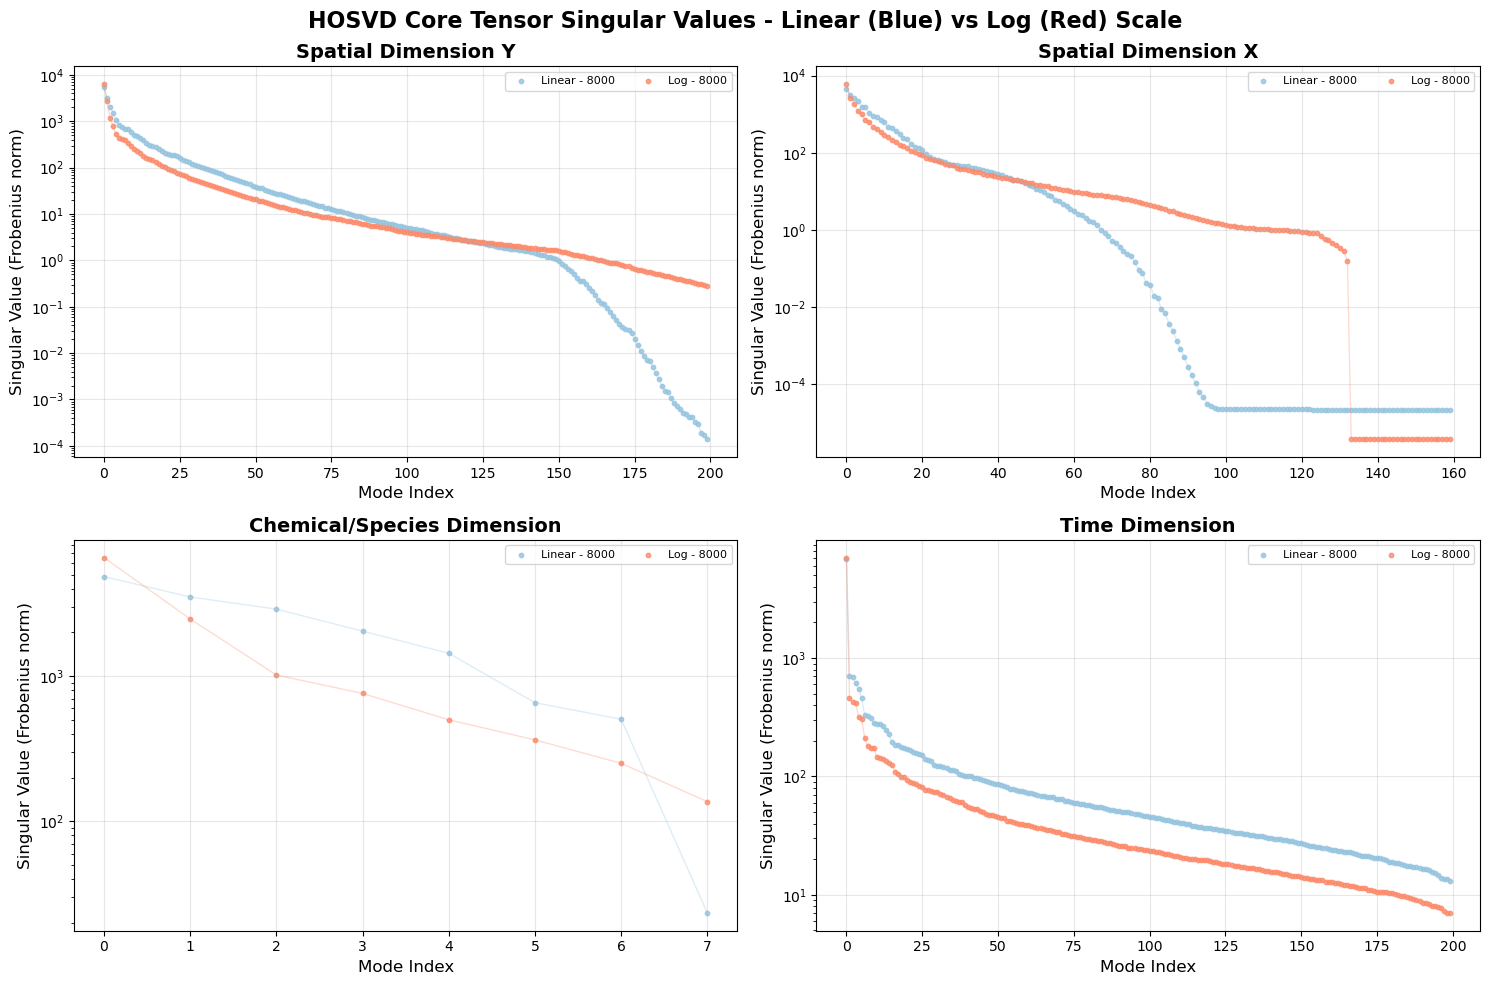

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Separate colors for Linear and Log scale
colors_linear = plt.cm.Blues(np.linspace(0.4, 0.9, len([k for k in decomposition_results.keys() if k.startswith("Linear")])))
colors_log = plt.cm.Reds(np.linspace(0.4, 0.9, len([k for k in decomposition_results.keys() if k.startswith("Log")])))

color_idx_linear = 0
color_idx_log = 0

for key, f in decomposition_results.items():
    core = f['core']
    
    # Determine if Linear or Log scale
    if key.startswith("Linear"):
        case_label = "Linear"
        color = colors_linear[color_idx_linear]
        color_idx_linear += 1
    else:
        case_label = "Log"
        color = colors_log[color_idx_log]
        color_idx_log += 1
    
    # Extract Reynolds number from key
    if 'Re' in key:
        re_num = key.split('Re')[-1].split('_')[0]
        dataset_name = f"{case_label} - Re {key.split('-')[-1][:4]}"
    else:
        dataset_name = f"{case_label} - {key.split('-')[-1][:4]}"
    
    # Mode 0: Spatial Y dimension
    sv_0 = [np.linalg.norm(core[i, :, :, :]) for i in range(core.shape[0])]
    ax = axes[0, 0]
    ax.scatter(range(len(sv_0)), sv_0, color=color, s=10, alpha=0.8, label=dataset_name)
    ax.plot(range(len(sv_0)), sv_0, color=color, alpha=0.3, linewidth=1)
    
    # Mode 1: Spatial X dimension
    sv_1 = [np.linalg.norm(core[:, i, :, :]) for i in range(core.shape[1])]
    ax = axes[0, 1]
    ax.scatter(range(len(sv_1)), sv_1, color=color, s=10, alpha=0.8, label=dataset_name)
    ax.plot(range(len(sv_1)), sv_1, color=color, alpha=0.3, linewidth=1)
    
    # Mode 2: Chemical/Species dimension
    sv_chem = [np.linalg.norm(core[:, :, i, :]) for i in range(core.shape[2])]
    ax = axes[1, 0]
    ax.scatter(range(len(sv_chem)), sv_chem, color=color, s=10, alpha=0.8, label=dataset_name)
    ax.plot(range(len(sv_chem)), sv_chem, color=color, alpha=0.3, linewidth=1)
    
    # Mode 3: Time dimension
    sv_time = [np.linalg.norm(core[:, :, :, i]) for i in range(core.shape[3])]
    ax = axes[1, 1]
    ax.scatter(range(len(sv_time)), sv_time, color=color, s=10, alpha=0.8, label=dataset_name)
    ax.plot(range(len(sv_time)), sv_time, color=color, alpha=0.3, linewidth=1)

# Format axes
ax = axes[0, 0]
ax.set_xlabel('Mode Index', fontsize=12)
ax.set_ylabel('Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Spatial Dimension Y', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=8, loc='best', ncol=2)

ax = axes[0, 1]
ax.set_xlabel('Mode Index', fontsize=12)
ax.set_ylabel('Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Spatial Dimension X', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=8, loc='best', ncol=2)

ax = axes[1, 0]
ax.set_xlabel('Mode Index', fontsize=12)
ax.set_ylabel('Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Chemical/Species Dimension', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=8, loc='best', ncol=2)

ax = axes[1, 1]
ax.set_xlabel('Mode Index', fontsize=12)
ax.set_ylabel('Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Time Dimension', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=8, loc='best', ncol=2)

fig.suptitle('HOSVD Core Tensor Singular Values - Linear (Blue) vs Log (Red) Scale', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


RECONSTRUCTION ERROR AND COMPRESSION ANALYSIS - LOG SCALE HOSVD

----------------------------------------------------------------------------------------------------
Analyzing Mode 0: Spatial Y (max modes: 200)
----------------------------------------------------------------------------------------------------


Mode 0: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]


  First mode - Error: 4.597465e-01, Compression: 159.07x
  Last mode  - Error: 3.926357e-05, Compression: 1.00x

----------------------------------------------------------------------------------------------------
Analyzing Mode 1: Spatial X (max modes: 160)
----------------------------------------------------------------------------------------------------


Mode 1: 100%|██████████| 159/159 [03:13<00:00,  1.22s/it]


  First mode - Error: 5.360876e-01, Compression: 127.93x
  Last mode  - Error: 5.224689e-10, Compression: 1.00x

----------------------------------------------------------------------------------------------------
Analyzing Mode 2: Chemical Species (max modes: 8)
----------------------------------------------------------------------------------------------------


Mode 2: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


  First mode - Error: 4.007176e-01, Compression: 7.87x
  Last mode  - Error: 1.912455e-02, Compression: 1.14x

----------------------------------------------------------------------------------------------------
Analyzing Mode 3: Time (max modes: 200)
----------------------------------------------------------------------------------------------------


Mode 3: 100%|██████████| 199/199 [02:47<00:00,  1.19it/s]


  First mode - Error: 1.577632e-01, Compression: 159.07x
  Last mode  - Error: 9.816799e-04, Compression: 1.00x

ANALYSIS COMPLETE


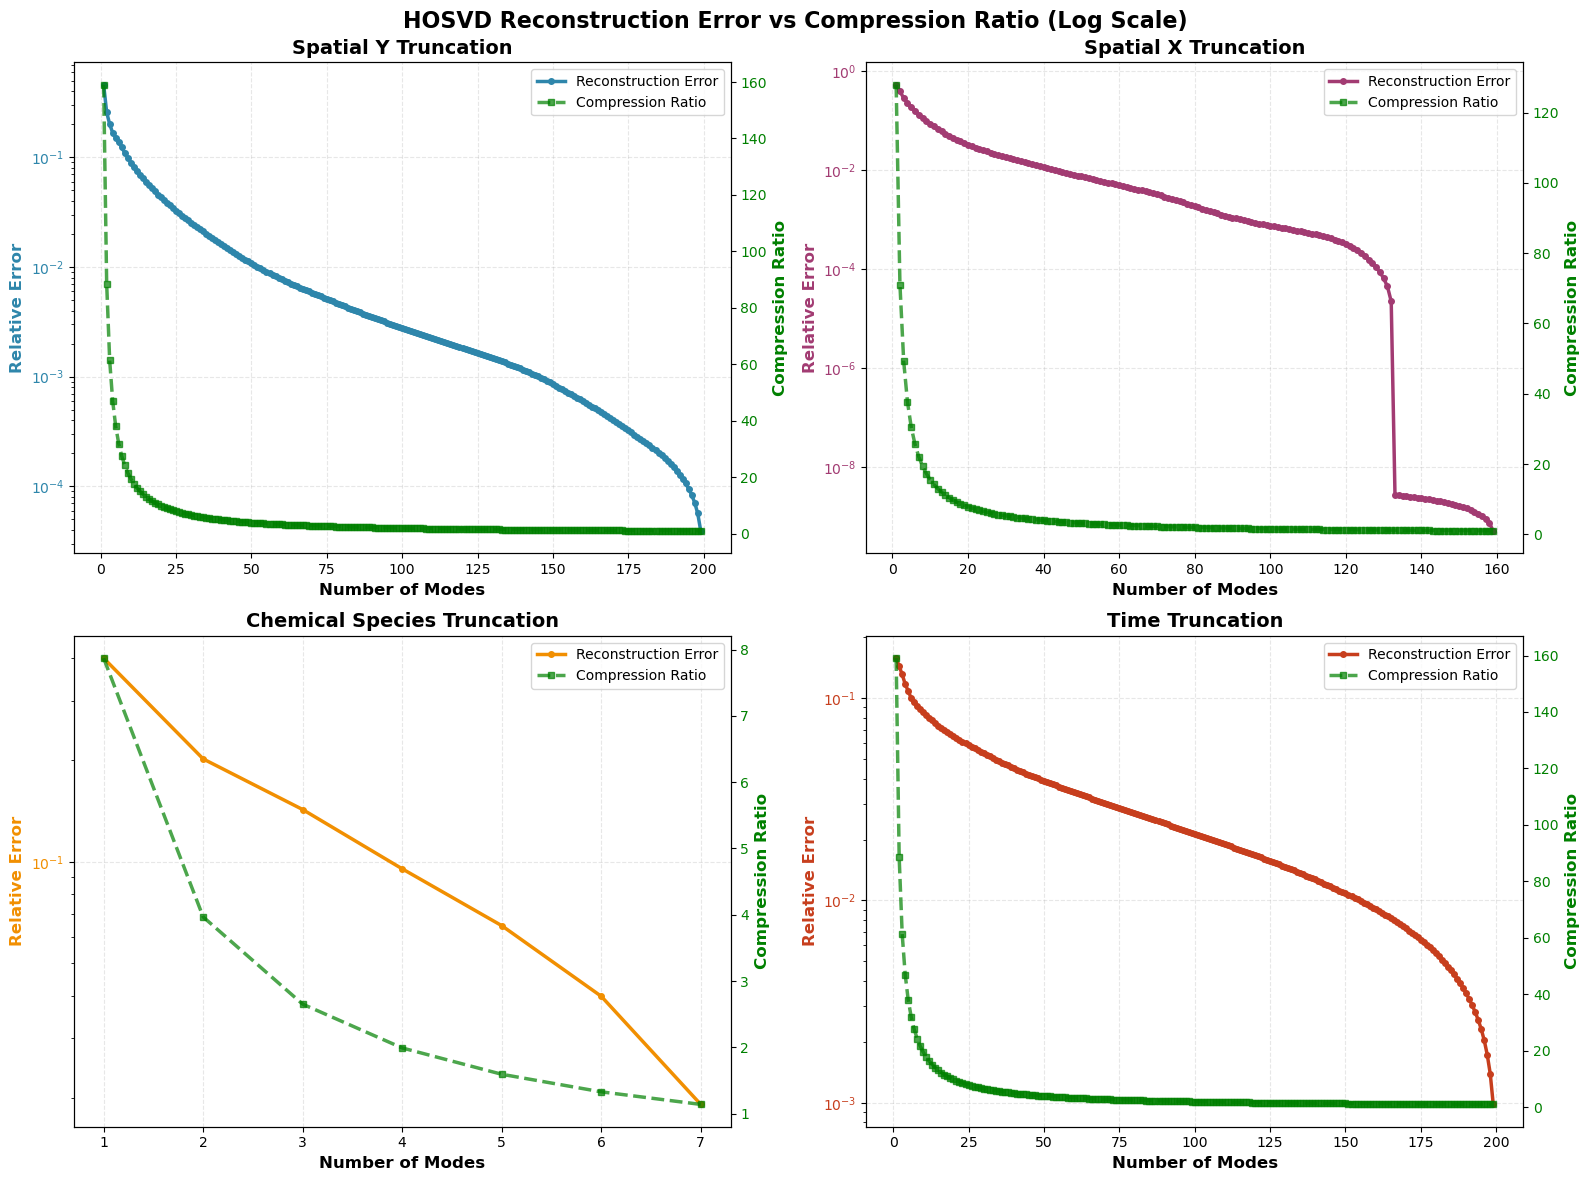


SUMMARY: Error at 50% Mode Retention
Spatial Y            - Modes: 100, Error: 2.791677e-03, Compression: 1.99x
Spatial X            - Modes:  80, Error: 1.882031e-03, Compression: 1.99x
Chemical Species     - Modes:   4, Error: 9.530140e-02, Compression: 1.99x
Time                 - Modes: 100, Error: 2.136272e-02, Compression: 1.99x


In [12]:
# ===== RECONSTRUCTION ERROR AND COMPRESSION ANALYSIS FOR LOG SCALE HOSVD =====

# Get the log scale decomposition
log_key = [k for k in decomposition_results.keys() if k.startswith("Log")][0]
log_result = decomposition_results[log_key]
core = log_result['core']
factors = log_result['factors']

# Get the original log-scaled tensor
original_tensor = tensors_scaled_log[list(tensors_scaled_log.keys())[0]]
original_size = np.prod(original_tensor.shape)

# Dimension names
dim_names = ['Spatial Y', 'Spatial X', 'Chemical Species', 'Time']
dim_shapes = core.shape

# Store results for plotting
results = {
    'modes': [],
    'errors': [],
    'compressions': [],
    'dim_names': []
}

print("\n" + "="*100)
print("RECONSTRUCTION ERROR AND COMPRESSION ANALYSIS - LOG SCALE HOSVD")
print("="*100)

# Analyze each dimension
for mode_idx in range(len(factors)):
    print(f"\n{'-'*100}")
    print(f"Analyzing Mode {mode_idx}: {dim_names[mode_idx]} (max modes: {dim_shapes[mode_idx]})")
    print(f"{'-'*100}")
    
    mode_indices = []
    mode_errors = []
    mode_compressions = []
    
    # Iteratively truncate this dimension
    for n_modes in tqdm(range(1, dim_shapes[mode_idx]), desc=f"Mode {mode_idx}"):
        # Create truncated factors
        truncated_factors = []
        truncated_core_shape = list(core.shape)
        truncated_core_shape[mode_idx] = n_modes
        
        for i, factor in enumerate(factors):
            if i == mode_idx:
                # Truncate this mode
                truncated_factors.append(factor[:, :n_modes])
            else:
                # Keep full factor
                truncated_factors.append(factor)
        
        # Truncate core tensor
        slices = [slice(None)] * core.ndim
        slices[mode_idx] = slice(0, n_modes)
        truncated_core = core[tuple(slices)]
        
        # Reconstruct tensor
        reconstructed = multi_mode_dot(truncated_core, truncated_factors, modes=range(tensor.ndim))
        
        # Calculate reconstruction error (relative Frobenius norm)
        error = np.linalg.norm(reconstructed - original_tensor) / np.linalg.norm(original_tensor)
        
        # Calculate compression ratio
        # Compressed storage: truncated core + all factor matrices
        truncated_core_size = np.prod(truncated_core.shape)
        factors_size = sum(f.shape[0] * (f.shape[1] if i != mode_idx else n_modes) 
                          for i, f in enumerate(factors))
        compressed_size = truncated_core_size + factors_size
        compression_ratio = original_size / compressed_size
        
        mode_indices.append(n_modes)
        mode_errors.append(error)
        mode_compressions.append(compression_ratio)
        
    # Store results
    results['modes'].extend([mode_indices] * 1)
    results['errors'].extend([mode_errors] * 1)
    results['compressions'].extend([mode_compressions] * 1)
    results['dim_names'].extend([dim_names[mode_idx]] * 1)
    
    print(f"  First mode - Error: {mode_errors[0]:.6e}, Compression: {mode_compressions[0]:.2f}x")
    print(f"  Last mode  - Error: {mode_errors[-1]:.6e}, Compression: {mode_compressions[-1]:.2f}x")

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)



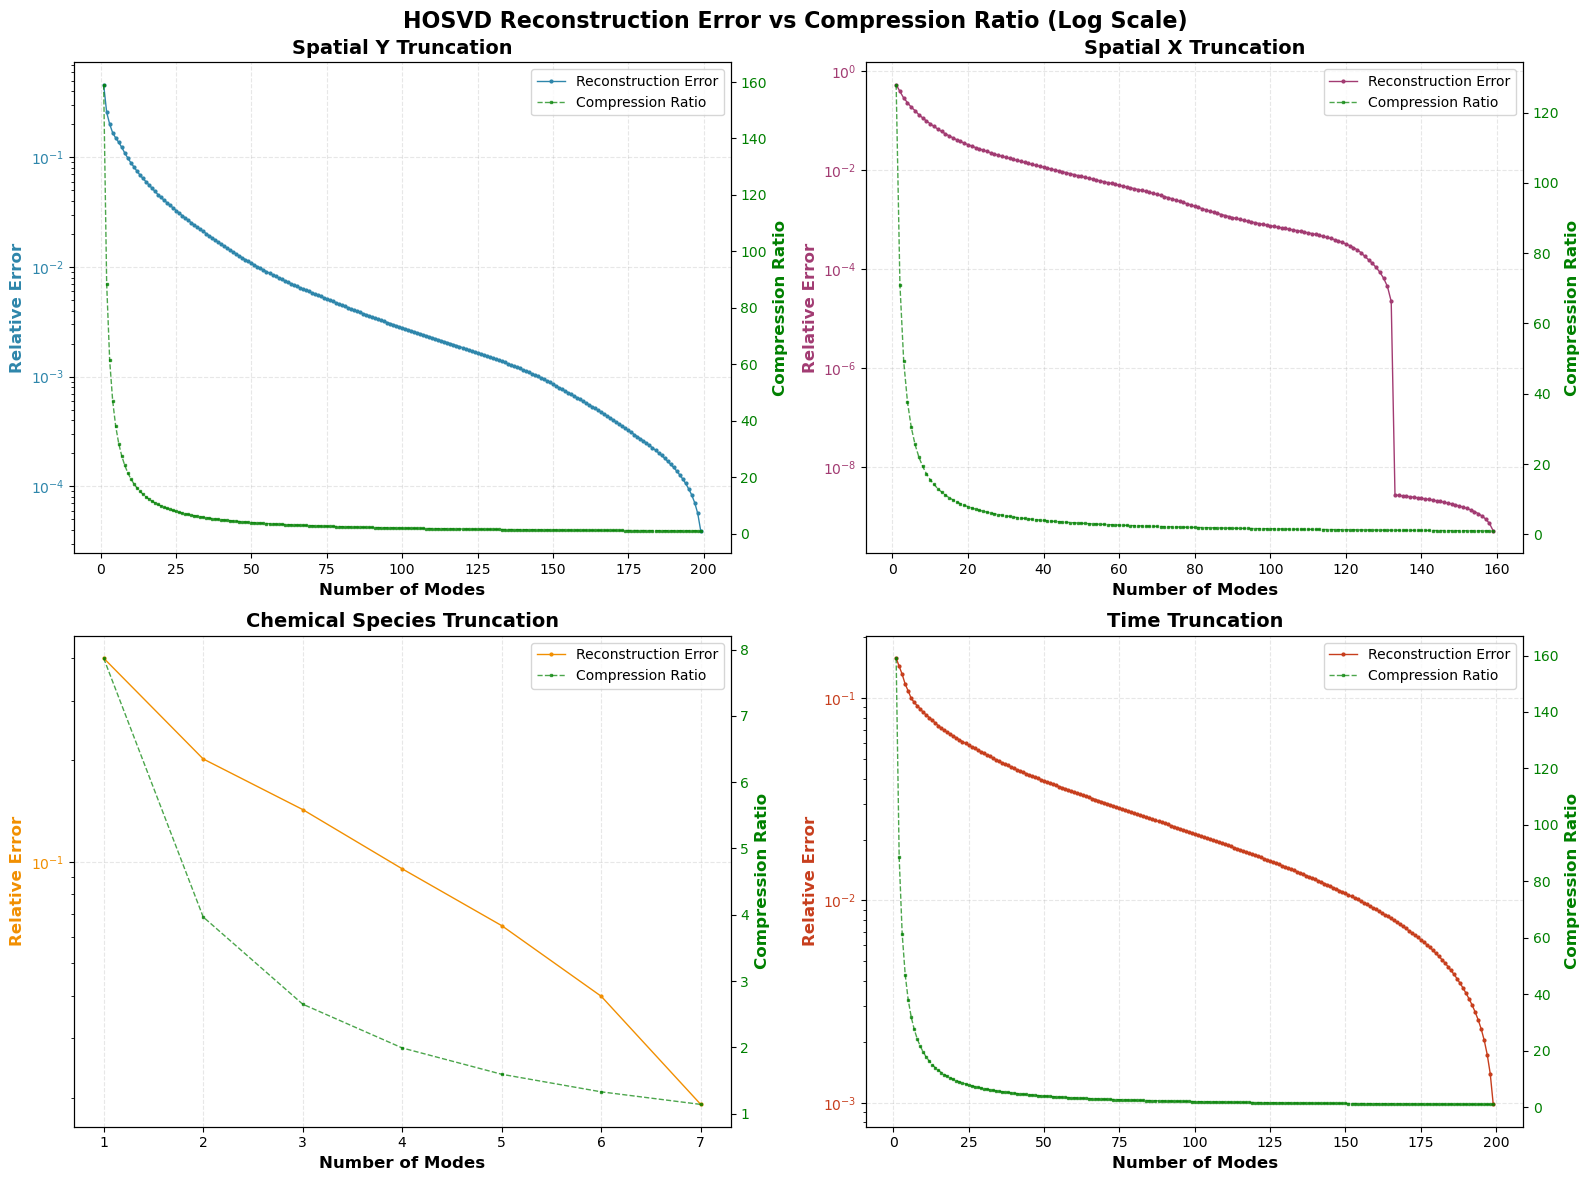


SUMMARY: Error at 50% Mode Retention
Spatial Y            - Modes: 100, Error: 2.791677e-03, Compression: 1.99x
Spatial X            - Modes:  80, Error: 1.882031e-03, Compression: 1.99x
Chemical Species     - Modes:   4, Error: 9.530140e-02, Compression: 1.99x
Time                 - Modes: 100, Error: 2.136272e-02, Compression: 1.99x


In [17]:
# ===== PLOTTING =====
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

for i in range(4):
    # Error plot
    ax_err = axes[i // 2, i % 2]
    ax_err.plot(results['modes'][i], results['errors'][i], 
                color=colors[i], linewidth=1, marker='o', markersize=2, 
                label='Reconstruction Error')
    ax_err.set_xlabel('Number of Modes', fontsize=12, fontweight='bold')
    ax_err.set_ylabel('Relative Error', fontsize=12, fontweight='bold', color=colors[i])
    ax_err.set_title(f'{results["dim_names"][i]} Truncation', 
                     fontsize=14, fontweight='bold')
    ax_err.tick_params(axis='y', labelcolor=colors[i])
    ax_err.set_yscale('log')
    ax_err.grid(True, alpha=0.3, linestyle='--')
    
    # Compression plot on secondary axis
    ax_comp = ax_err.twinx()
    ax_comp.plot(results['modes'][i], results['compressions'][i], 
                 color='green', linewidth=1, marker='s', markersize=2,
                 linestyle='--', label='Compression Ratio', alpha=0.7)
    ax_comp.set_ylabel('Compression Ratio', fontsize=12, fontweight='bold', color='green')
    ax_comp.tick_params(axis='y', labelcolor='green')
    
    # Combine legends
    lines1, labels1 = ax_err.get_legend_handles_labels()
    lines2, labels2 = ax_comp.get_legend_handles_labels()
    ax_err.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

fig.suptitle('HOSVD Reconstruction Error vs Compression Ratio (Log Scale)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ===== SUMMARY STATISTICS =====
print("\n" + "="*100)
print("SUMMARY: Error at 50% Mode Retention")
print("="*100)
for i in range(4):
    half_idx = len(results['modes'][i]) // 2
    print(f"{results['dim_names'][i]:20s} - Modes: {results['modes'][i][half_idx]:3d}, "
          f"Error: {results['errors'][i][half_idx]:.6e}, "
          f"Compression: {results['compressions'][i][half_idx]:.2f}x")
print("="*100)

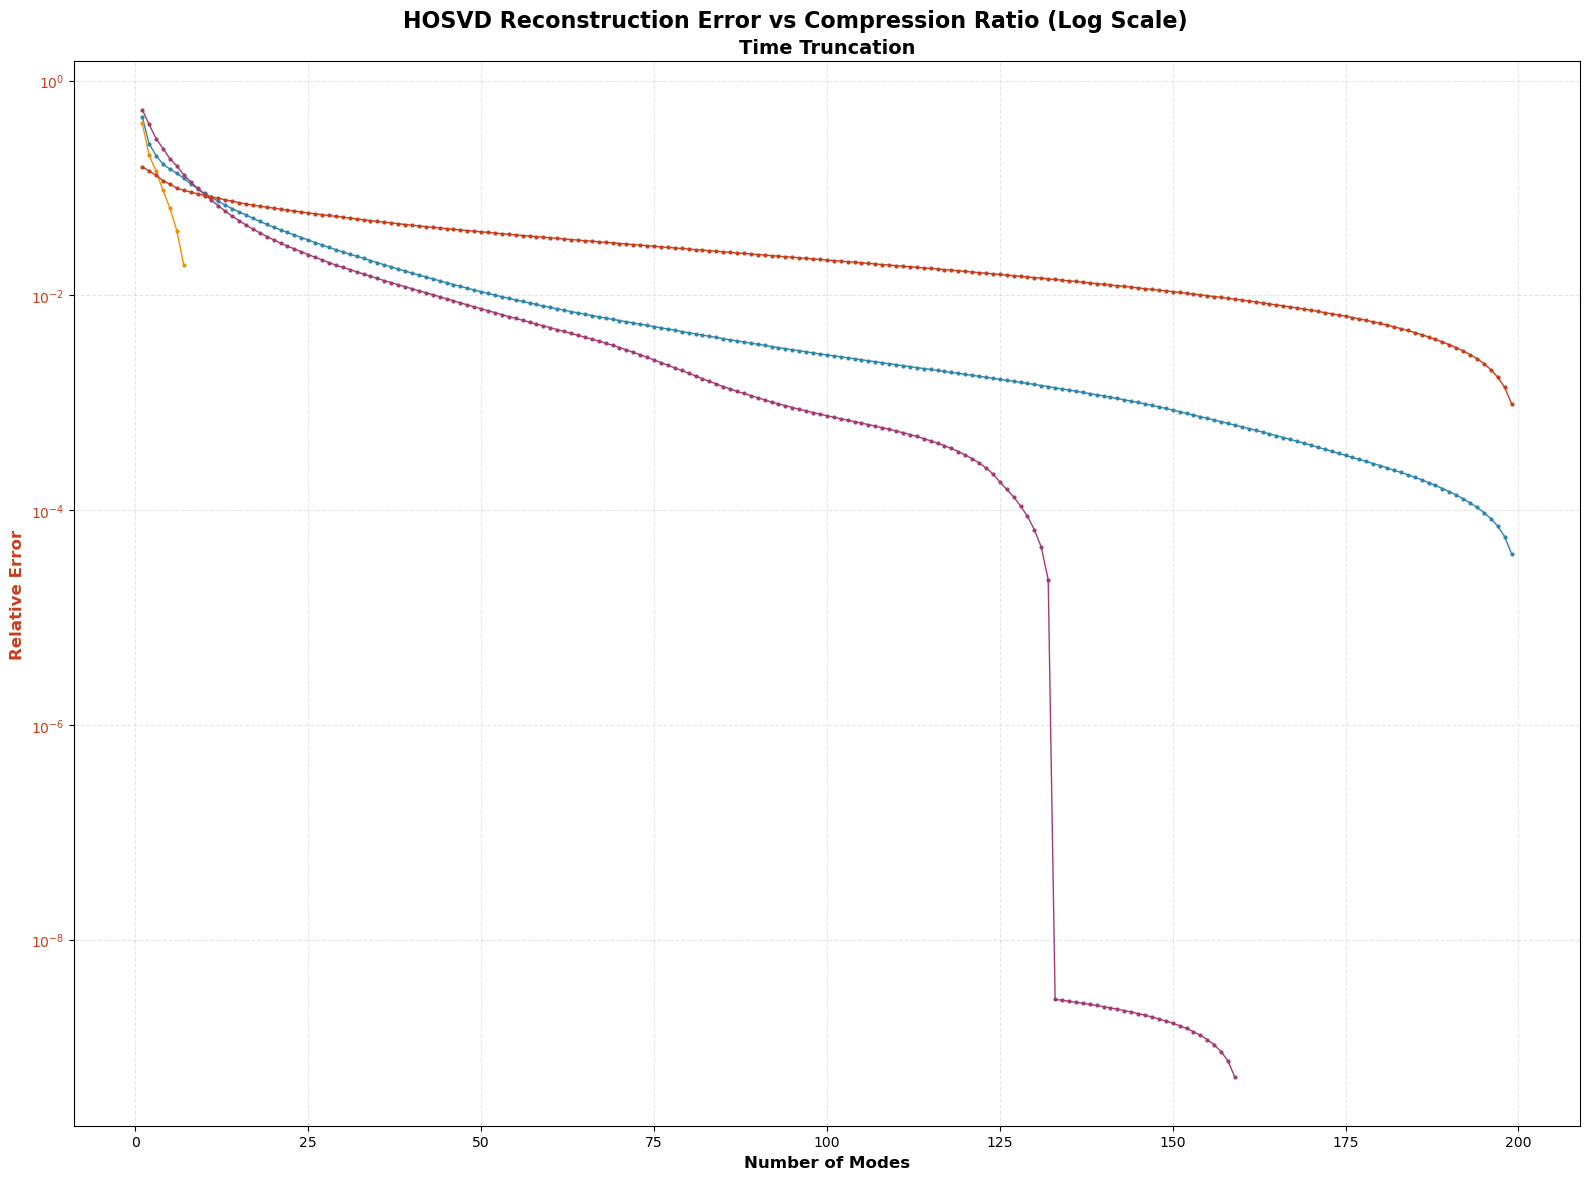

In [ ]:
# ===== PLOTTING =====
fig, axes = plt.subplots(1, 1, figsize=(16, 12))

colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

for i in range(4):
    ax_err = axes
    
    ax_err.plot(results['modes'][i], results['errors'][i], 
                color=colors[i], linewidth=1, marker='o', markersize=2, 
                label='Reconstruction Error')
    ax_err.set_xlabel('Number of Modes', fontsize=12, fontweight='bold')
    ax_err.set_ylabel('Relative Error', fontsize=12, fontweight='bold', color=colors[i])
    ax_err.set_title(f'{results["dim_names"][i]} Truncation', 
                     fontsize=14, fontweight='bold')
    ax_err.tick_params(axis='y', labelcolor=colors[i])
    ax_err.set_yscale('log')
    ax_err.grid(True, alpha=0.3, linestyle='--')
    
    """
    ax_comp = ax_err.twinx()
    ax_comp.plot(results['modes'][i], results['compressions'][i], 
                 color='green', linewidth=1, marker='s', markersize=2,
                 linestyle='--', label='Compression Ratio', alpha=0.7)
    ax_comp.set_ylabel('Compression Ratio', fontsize=12, fontweight='bold', color='green')
    ax_comp.tick_params(axis='y', labelcolor='green')
    
    # Combine legends
    lines1, labels1 = ax_err.get_legend_handles_labels()
    lines2, labels2 = ax_comp.get_legend_handles_labels()
    ax_err.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)
    """
fig.suptitle('HOSVD Reconstruction Error vs Compression Ratio (Log Scale)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()